In [1]:
# Headers
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from copy import deepcopy
from skimage.feature import greycomatrix, greycoprops
import cv2  
from numpy.linalg import det
from skimage import util, exposure
from math import sqrt, ceil
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from time import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# global variables
black_value = np.float64(-1408.5106382978724)
images_filename = 'tr_im.nii'
masks_filename = 'tr_mask.nii'

In [3]:
def get_vals(mask):
    vals = []
    x, y = mask.shape
    for i in range(x):
        for j in range(y):
            if mask[i,j] not in vals:
                vals.append(mask[i][j])

    vals.remove(0)
    return vals

In [4]:
def apply_mask(img, mask, class_id):
    heigh, width = img.shape
    tmp = deepcopy(img)
    lineal_array = np.array(0)
    for x in range(heigh):
        for y in range(width):
            # Set pixel as black color if is not inside this mask
            if mask[x,y] != np.float64(class_id):
                tmp[x,y] = black_value
            # Count pixels inside this mask
            else:
                lineal_array = np.append(lineal_array, tmp[x,y])
    # In tmp is saved the image with mask applied
    # In lineal_array is saved just the mask's pixels
    lineal_array = np.delete(lineal_array, 0)
    return tmp, lineal_to_matrix(lineal_array)

In [5]:
def calculate_media_lineal_arr(array):
    length = array.shape[0]
    media = np.float64(0)
    for x in range(length):
        media += array[x]
    media = media/length
    return media

In [6]:
def lineal_to_matrix(lineal_array):
    sqrt_ = ceil(sqrt(lineal_array.shape[0]))
    media = calculate_media_lineal_arr(lineal_array)
    missing_values = sqrt_**2 - lineal_array.shape[0]
    #print("missing ", missing_values)
    # Complete square matrix
    for x in range(missing_values):
        lineal_array = np.append(lineal_array, media)
    
    return lineal_array.reshape([sqrt_, sqrt_])

In [7]:
def show_slice_mask(slicei, mask):
    """ Function to display images and mask """
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(slicei.T,  cmap="gray", origin="lower")
    ax[0].set_title('Image')
    ax[1].imshow(mask.T, cmap="gray", origin="lower")
    ax[1].set_title('Mask')
    plt.show()

In [8]:
def glcm_properties(image):
    distancias = [1,2]
    #0 -> Oeste a este, -np.pi/2 -> Norte a sur
    angulos = [0, -np.pi/2]

    # Calculate properties for just one superpixel using the
    # respective mask  
    glcm = greycomatrix(image, 
                        distances = distancias, 
                        angles = angulos,
                        symmetric=True, 
                        normed=True)
                        
    energyResults = greycoprops(glcm, 'energy')
    contrastResults = greycoprops(glcm, 'contrast')
    correlationResults = greycoprops(glcm, 'correlation')
    
    return [np.mean(contrastResults), np.mean(energyResults), np.mean(correlationResults)]

In [9]:
def training(imgs, masks):
    height, width, num_images = imgs.shape
    # Class dictionary to store every property for this class as key
    classes_dict = {}
    # loop over the images
    for x in range(num_images):
        if x+1 % 10 == 0:
            print("{} imagenes procesadas".format(x))
        # Get every class in the current image
        classes = get_vals(masks[:,:,x])
        # loop for every class in the current image 
        for j in classes:
            if not int(j) in classes_dict:
                classes_dict[int(j)] = [[0, 0], [0, 0], [0, 0]]
            # getting the square matrix for the current class
            tmp, matrix_mask = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            # Contrast, Correlation, Energy properties
            props = glcm_properties(matrix_mask.astype(np.uint8))
            # Adding every class's property values
            for z in range(len(props)):
                classes_dict[int(j)][z][0] += props[z]
                classes_dict[int(j)][z][1] += 1

    # Getting average for every class's property
    for id_ in classes_dict.keys():
        for z in range(3):
            classes_dict[id_][z][0] = classes_dict[id_][z][0]/classes_dict[id_][z][1]
            classes_dict[id_][z] = classes_dict[id_][z][0]
    #0: correlation, 1: contrast, 2: energy
    print(classes_dict)
    return classes_dict

In [10]:
def main():
    to_show = 3
    imgs = nib.load(images_filename).get_fdata()
    masks = nib.load(masks_filename).get_fdata()
    train = training(imgs, masks)
    #print(train)
    return train
    """
    #for x in range(3):
    for x in [25, 26, 27]:
        print("Image no ", x)
        classes = get_vals(masks[:,:,x])
        show_slice_mask(imgs[:,:,x], masks[:,:,x])
        for j in classes:
            tmp, matrix_mask = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            print("class ", j)
            print(type(matrix_mask))
            #show_slice_mask(tmp, masks[:,:,x])
            show_slice_mask(tmp, matrix_mask)
            print(glcm_properties(matrix_mask.astype(np.uint8)))
            #create_matrix(tmp)
        #print(get_prop(imgs[:,:,x].astype(np.uint8), masks[:,:,x].astype(np.uint8)))
        #get_every_mask(imgs[:,:,x], masks[:,:,x])
    """

In [11]:
start_time = time()
train = main()
end_time = time() - start_time
print("Tiempo de entrenamiento: ", end_time)

{2: [10596.72999509758, 0.02617827123359886, 0.06471160120920959], 1: [10197.259514566633, 0.014172971679995441, 0.08630341160591291], 3: [11714.680387832675, 0.043996813527231435, 0.05819362993873664]}
Tiempo de entrenamiento:  222.57135939598083


In [12]:
def getROI(img, segments):
    auxiliar = [] 
    for (i, segVal) in enumerate(np.unique(segments)): #Accediendo a cada superpixel
        # construct a mask for the segment
        mask = np.zeros(img.shape[:2], dtype = "uint8")
        mask[segments == segVal] = 255
        mask = cv2.bitwise_and(img, img, mask = mask)
        auxiliar.append(mask) #Se agrega cada una de las mascarar
    
    #print("Función getROI, len(auxiliar) = ", len(auxiliar))
    return auxiliar

In [13]:
#funcion para segmentar superpíxeles
def SLIC(img, k):
    image = img_as_float(img)

    segments = slic(image, k, sigma = 5)
    # show the output of SLIC
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
    plt.show()

#Para cada máscara, segmentamos en superpixeles
def getSuperPixels(tmp, number):
    #aux = np.asarray(cv2.normalize(tmp, 0, 255, cv2.NORM_MINMAX), dtype=np.double)
    aux = np.asarray(cv2.normalize(tmp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),dtype=np.double)
    segments_slic = slic(aux, n_segments = number, compactness=0.28, sigma=0, enforce_connectivity=True, slic_zero=False)
    #print(f"Segmentos del algoritmo SLIC: {len(np.unique(segments_slic))}")
    
    ### Commented | Despliega imagen de superpixeles | 5-junio-2020
    # show the output of SLIC
    fig = plt.figure("Superpixels")
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(aux, segments_slic))
    plt.axis("off")
    plt.show()
    
    superpixels = np.asarray(getROI(aux, segments_slic)) #Lista de superpixeles

    res = []
    for i in range(len(superpixels)): #Iteramos sobre el número de superpixeles
        prueba = np.asarray(cv2.normalize(superpixels[i], 0, 255, cv2.NORM_MINMAX), dtype=int)
        valuePixel = np.unique(prueba)
        if (len(valuePixel) > 1):
            res.append(prueba)
    
    return res

In [14]:
def apply_superpixel(img, superpixel):
    heigh, width = img.shape
    lineal_array = np.array(0)
    for x in range(heigh):
        for y in range(width):
            # append pixels inside this superpixel
            if superpixel[x,y] == np.int64(8):
                lineal_array = np.append(lineal_array, img[x,y])
    # In tmp is saved the image with mask applied
    # In lineal_array is saved just the mask's pixels
    lineal_array = np.delete(lineal_array, 0)
    return lineal_to_matrix(lineal_array)

In [15]:
def trainingKnn(imgs, masks):
    height, width, num_images = imgs.shape
    
    X = []
    Y = []
    # loop over the images
    for x in range(num_images):
        if (x+1) % 10 == 0:
            print("{} imagenes procesadas".format(x+1))
        # Get every class in the current image
        classes = get_vals(masks[:,:,x])
        # loop for every class in the current image 
        for j in classes:
            # getting the square matrix for the current class
            tmp, matrix_mask = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            # Contrast, Correlation, Energy properties
            X.append(glcm_properties(matrix_mask.astype(np.uint8)))
            Y.append(int(j))

    return (X, Y)

In [19]:
imgs = nib.load(images_filename).get_fdata()
masks = nib.load(masks_filename).get_fdata()
print("training KNN")
X, Y = trainingKnn(imgs, masks)

training KNN
10 imagenes procesadas
20 imagenes procesadas
30 imagenes procesadas
40 imagenes procesadas
50 imagenes procesadas
60 imagenes procesadas
70 imagenes procesadas
80 imagenes procesadas
90 imagenes procesadas
100 imagenes procesadas


In [29]:
def classifier():
    imgs = nib.load(images_filename).get_fdata()
    masks = nib.load(masks_filename).get_fdata()
    #print("training KNN")
    #X, Y = trainingKnn(imgs, masks)
    # neighbors equals to number os classes
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X, Y)
    bay = GaussianNB()
    bay.fit(X, Y)
    print("Done")
    tmp = np.zeros((512,512))
    count = 0
    for x in range(1):
        print("\nImage no ", x)
        superpixels = getSuperPixels(imgs[:,:,x], 300)
        print("SP reducidos = ", len(superpixels))
        for k in range(len(superpixels)):
            if (k+1) % 30 == 0:
                print("Working with superpixel ", k)
            sp = apply_superpixel(imgs[:,:,x], superpixels[k])
            h, w = sp.shape
            # Sometimes have empty superpixels
            if h*w !=0:
                #print("sp ", k)
                sp_props = glcm_properties(sp.astype(np.uint8))
                if neigh.predict([sp_props])[0] == bay.predict([sp_props])[0]:
                    count +=1
                    tmp += superpixels[k]
                    #show_slice_mask(tmp,superpixels[k])
        show_slice_mask(imgs[:,:,x],tmp)
        print(count)

Done

Image no  0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


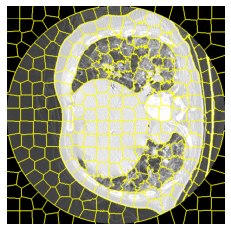

SP reducidos =  277
Working with superpixel  29
Working with superpixel  59
Working with superpixel  89
Working with superpixel  119
Working with superpixel  149
Working with superpixel  179
Working with superpixel  209
Working with superpixel  239
Working with superpixel  269


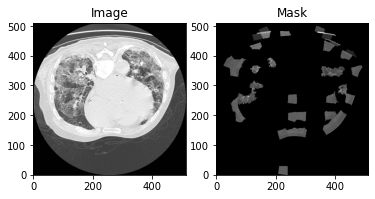

35


In [30]:
classifier()